In [1]:
import sys  
sys.path.insert(0, '../search-engine')
from utils import *
from sklearn.manifold import TSNE
import numpy as np
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from collections import Counter

## Top-20 lists of ranked documents
FER-HO UTILITZANT FUNCIONS PERQ HEM DE GUARDAR TSV FILES

In [3]:
# Import data and select a smaller sample 
data = get_tweets(None, None, mode = "read", data_directory = '../data/')
sample = 10000
data = data[:sample]

In [ ]:
# TF-IDF
run -i 'search_engine.py' -s tf-idf -tk 20 -sm 50000

In [ ]:
# WORD2VEC
run -i 'search_engine.py' -s w2v -tk 20 -sm 50000

## TSNE

In [88]:
# Create tweets dict
tweets_df = pd.DataFrame.from_dict(create_tweets_dict(data), orient='index', columns = ["Text"])

In [89]:
# Compute tweets embeddings using word2vector

# Collect tweets' terms to create w2v_model
words = []
for tweet in data:
    try: text = tweet["full_text"]
    except: text = tweet["text"]
    words.append(normalize_text(text))
    
# Store normalized text in tweets dict    
tweets_df["Normalized_Text"] = words
tweets_df["Normalized_Text"] = tweets_df["Normalized_Text"].apply(lambda x: ' '.join(x))
    
# Initialize word2vec model    
w2v_model = Word2Vec(sentences = words, size = 20, window = 10, min_count = 0, negative = 10, sg = 0)

# Compute tweets' vector embedding 
vectors = np.zeros((len(data), w2v_model.vector_size))
for i, tweet in enumerate(data):
    try: text = tweet["full_text"]
    except: text = tweet["text"]
    vectors[i,:] = mean_w2v(text, w2v_model, tweet=False)

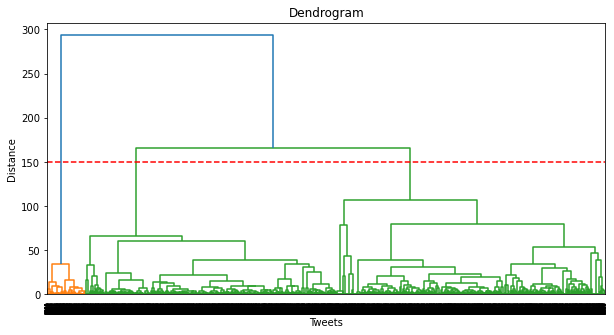

In [5]:
# Compute dendrogram to estimate the number of clusters
X = vectors
plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.axhline(y=150, color='r', linestyle='--')
plt.title("Dendrogram")
plt.ylabel("Distance")
plt.xlabel("Tweets")
plt.show()

In [91]:
# Clustering 
n_clusters = 3
clustering = AgglomerativeClustering(n_clusters, linkage='ward').fit(X)

assert(len(set(clustering.labels_)) == n_clusters)
tweets_df["Cluster"] = clustering.labels_

In [93]:
# Initialize TSNE model 
tsne_model_en_2d = TSNE(perplexity=50, n_components=2, init='pca', n_iter=3500, random_state=32)

# Transform w2v embeddings into 2d arrays 
embeddings_2d = np.array(tsne_model_en_2d.fit_transform(X))

In [94]:
# Prepare data for plot
clusters = {}
for vector, label, dict_key in zip(embeddings_2d, clustering.labels_, tweetsDict):
    try: clusters[label] = np.vstack((clusters[label], vector))
    except: clusters[label] = vector

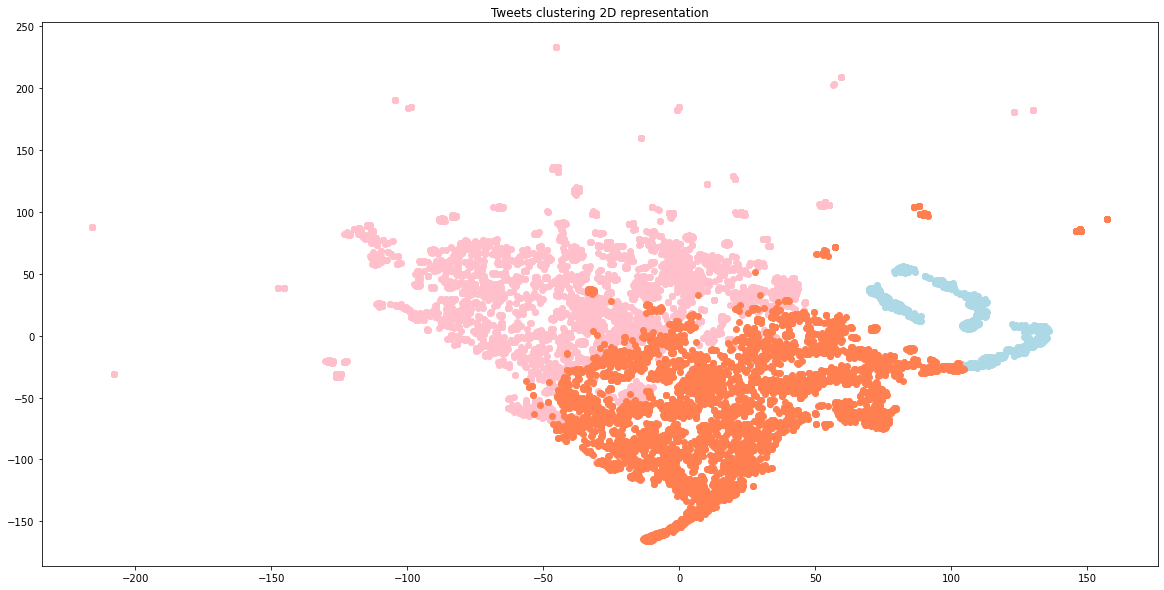

In [107]:
# Plot clusters into 2D 
plt.figure(figsize=(20,10))
color = ["pink", "lightblue", "coral", "gray"]

for i in range(n_clusters):
    plt.scatter(clusters[i][:, 0], clusters[i][:, 1], color = color[i])
    plt.title("Tweets clustering 2D representation")
    # FICAR LABELS I AXIS (X, Y) I COLORS MONOS
plt.show()

## Clustering interpretation

In [108]:
for i in range(n_clusters):
    print("\nFive random tweets from cluster", i)
    print(tweets_df[tweets_df["Cluster"] == i]["Text"].sample(5).values)


Five random tweets from cluster 0
['RT @tweettruth2me: I’m not a Republican or a Democrat. I’m a party of one, and I stand for individual liberty for all.'
 'RT @ColumbiaBugle: The Moment Of The Night\n\nGeorgia Crowd Chants At @KLoeffler &amp; @sendavidperdue: \n\n"FIGHT FOR TRUMP! FIGHT FOR TRUMP! FIGH…'
 'Stop the steal! Write in Trump! https://t.co/KdH2bahxOY'
 'Trump is totally out of control. The 25th amendment was designed for this circumstance'
 "RT @mmpadellan: While trump is destroying Loeffler &amp; Perdue's chances with his insane #TrumpRally, let's help Warnock &amp; Ossoff WIN!\n\nWe're…"]

Five random tweets from cluster 1
['RT @bekhayaalii2_O: 🍺\n\nI vote #VishalVashishtha for Ishq Mein Marjawan 2 \n\n#TVPersonalityWithRajBaddhan\n\n@BizAsia @SabrasRadio @RajBaddhan…'
 'RT @Moni__Ka_: I vote #VishalVashishtha for Ishq Mein Marjawan 2 \n\n#TVPersonalityWithRajBaddhan\n\n@BizAsia @SabrasRadio @RajBaddhan \n ♥️'
 'RT @ammuvidya95: @RajBaddhan @SabrasRadio @BizAsia \n\nI v

In [137]:
for i in range(n_clusters):
    lst_tweets = tweets_df[tweets_df["Cluster"] == i]["Normalized_Text"]
    lst_words = []
    for tweet in lst_tweets:
        lst_words += tweet.split()
        
    print("\nMost common words in cluster {}:".format(i))
    for word, value in Counter(lst_words).most_common(5):
        print(word)


Most common words in cluster 0:
trump
realdonaldtrump
president
election
biden

Most common words in cluster 1:
vote
sabrasradio
rajbaddhan
bizasia
tvpersonalitywithrajbaddhan

Most common words in cluster 2:
vote
trump
biden
amp
dont


In [139]:
tweets_df[["Text", "Cluster"]].to_csv("../other-outputs/clustering_output_10000.csv")